In [1]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd

In [5]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [98]:
sigles = 'A', 'B', 'F'

In [99]:
from lxml import etree

NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 

def extract_lines(xml_file):
    lines = {}
    tree = etree.parse(xml_file)
    etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False)
    for text_node in tree.iterfind('//MVN:text', namespaces=NSMAP):
        try:
            title = text_node.attrib['n']
        except KeyError:
            continue
        for line_node in text_node.iterfind('.//MVN:l', namespaces=NSMAP):
            k = title + '-' + line_node.attrib['n']
            line_text = ''
            for sub_node in line_node.iterdescendants():
                if sub_node.text:
                    line_text += sub_node.text
                if sub_node.tail:
                    line_text += sub_node.tail                
                if sub_node.tag.endswith('choice'):
                    line_text += ' '
                
            line_text = ' '.join(line_text.strip().split())
            lines[k] = line_text
    return lines

In [100]:
d = extract_lines(f'../data/xml_martijn/xml_{sigles[2]}.xml')
for k in sorted(d):
    print(k, d[k])

Colofon-001 Merckt gheleerde bekent van binnen
Colofon-002 
Colofon-003 
Colofon-004 Jakob van meyrlant wijs van zinnen
Colofon-005 
Colofon-006 
Colofon-007 welckke materie ende dicht vol minnen
Colofon-008 Is seer inkorreckdt gheworden int dinnen
Colofon-009 
Colofon-010 
Colofon-011 
Colofon-012 
Colofon-013 
Colofon-014 
Colofon-015 
Colofon-016 
Colofon-017 -
Colofon-018 Jakob van
Colofon-019 
Colofon-020 
Colofon-021 Belghica Historia/ In zijn derde
Colofon-022 van merlant dezen
Colofon-023 kleyn stat in een bij brugghe vlaenderen
Colofon-024 
Colofon-025 retorizien endeJacob Van meerlant onder de clocken
Colofon-026 schrijuen
Colofon-027 heeft ende onder onder ander subtijle onder
Colofon-028 naturen
Colofon-029 der naturen wonderlijckheden
Colofon-030 
Colofon-031 hem zelf beschreuen van
Colofon-032 heeft oock ghemaeckt ende
Colofon-033 druck inden
Colofon-034 oock in octauo ende
Colofon-035 dit boeck dat hier na volcht den duytsschen ende
Colofon-036 Is oock ghedruckt in quart

Eerste Martijn-339 DEerste minne es soe groot
Eerste Martijn-340 Dat alleene dat god ye geboot
Eerste Martijn-341 En volprijsde niet haer weerde
Eerste Martijn-342 Ja sij trac themels broot
Eerste Martijn-343 Hier neder maghet scoot inder
Eerste Martijn-344 Onder der ioden zweerde
Eerste Martijn-345 es god die merct al bloot Minne
Eerste Martijn-346 Wie anders mochten bringen noot inder
Eerste Martijn-347 Hem diet al verueerde
Eerste Martijn-348 Dan hij hem dair in besloot
Eerste Martijn-349 Die doer sijn bloet root minne
Eerste Martijn-350 Storte hier neder op deerde
Eerste Martijn-351 in minne openbaerde Ende
Eerste Martijn-352 Wien dat sulke es cont minne
Eerste Martijn-353 Als karitate hij es gesont
Eerste Martijn-354 Men mach hem niet verblinden
Eerste Martijn-355 Al laghe hij hellen gront inder
Eerste Martijn-356 Waer hij mede ghewont daer
Eerste Martijn-357 Hine waer niet in ellenden
Eerste Martijn-358 god en wille den riken vont Mer
Eerste Martijn-359 sondare no Gheenen hont gh

Tweede Martijn-114 Datti hem can ghehelpen yet
Tweede Martijn-115 Hine doelt als hijt selue siet
Tweede Martijn-116 Hine const hem niet bedwingen
Tweede Martijn-117 Hine sterf bij desen dinghen
Tweede Martijn-118 Medea toont ons selue dat
Tweede Martijn-119 Die rouede stal hairs ende «scat» vaders
Tweede Martijn-120 Ende verslouch haren broeder
Tweede Martijn-121 Om naersoen dies hair cume bat
Tweede Martijn-122 Sij liet conincrike scat ende
Tweede Martijn-123 Vader ende suster ende moeder
Tweede Martijn-124 Nochtan sij alleene sat daer
Tweede Martijn-125 Wijsde haer redene den pat rechten
Tweede Martijn-126 Al volghede zij den loeder
Tweede Martijn-127 therte was hair so mat Maer
Tweede Martijn-128 Dair in hadde gemaect .j. gat minne
Tweede Martijn-129 Wille hielt den roeder
Tweede Martijn-130 Al was die redene vroeder
Tweede Martijn-131 EXempel vindic getal sonder
Tweede Martijn-132 Die met mi lyen souden al
Tweede Martijn-133 Dat ic haer dleuen gaue
Tweede Martijn-134 Die mi therte 

In [101]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml')

100%|██████████| 3/3 [00:00<00:00, 33.22it/s]


In [102]:
print(mss.keys())

dict_keys(['A', 'B', 'F'])


In [103]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [104]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        print('=================')
        print(line1, '|', line2)
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry)
        print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))

  0%|          | 0/3 [00:00<?, ?it/s]

Vut monde redene gaen dinen | Vte monde dinen gaen woirden
Vut- monde redene- gaen -di-nen
V-te monde --dinen gaen woirden
Ende al ieghen verscheet | Jeghen al weersteet
-Ende- al ieghen verscheet
Jeghen al ---we---ers-teet
Mac mi dies in inne | Maec mi des in jnne
Ma-c mi dies in inne
Maec mi d-es in jnne
Haerre twier hire in minne vonde | Hairer beder hi dair minne vonde in
Haer-re twier hire in minne vonde---
Hairer- beder hi dair minne vonde in
gode benedyen Maer | gode benedien Mer
gode benedyen Maer
gode benedien M-er
Hier toe es gheen verwinnen | Hier ieghen nes gheen verwinnen
Hier --toe- -es gheen verwinnen
Hier ieghen nes gheen verwinnen
Daer leuet sonder vaer men | leuet Dairmen vaer sonder
Daer leuet -sonder vaer ---men
-----leuet Dairmen vaer sonder
Wie was van oint ghescent minnen | Wie was van oyt ghescent minnen
Wie was van oint ghescent minnen
Wie was van o-yt ghescent minnen
Ghedanct si soes menichfout | Gheloeft so sie dusentichuout
Ghedanct si soes --men-ichfout
Ghe

Ende volghen hare die ware--- ----hem ontfloen
om der weerelt eere Ende | Off nader ere werelt
-om --der weerelt eere Ende
Off nader --ere-- were---lt
Waert so dat ghi hu sciet van | Wairt so dat ghi v schiet van
Waert so dat ghi hu sc-iet van
Wairt so dat ghi -v schiet van
Bi redenen die ic telle | Bi die ic telle redenen
Bi redenen die ic tell-------e-
Bi-------- die ic telle redenen
eist dat Maer ter men menscheit keere | est Mer datment ter kere menscheit
eist---- dat Mae-r ter me-n menscheit keere
e-st Mer dat--ment ter kere menscheit------
Amen jacop lieue gheselle | Amen iacop lieue gheselle
Amen jacop lieue gheselle
Amen iacop lieue gheselle
Dat ic di doe noch heden ghien | Dat ic doe noch heyden ghien
Dat ic di doe noch he-den ghien
Dat ic--- doe noch heyden ghien
Dat men te lettel ghetrouwe kint | luttel Datmen vint trauwen
Dat men --t-e- lettel ghetrouwe kint
lut-tel Datmen vint-- ---trauwe---n-
Ic zwerdi dat bi marien | Des hopic an marien
-Ic zwerdi- dat bi marien
Des --ho

Van d-at ic niet en wiste----
Waerstu een dorp du spraex coen van | Wairstu een dorper du spraex «koen» van
Waerstu een dorp-- du spraex -coen- van
Wairstu een dorper du spraex «koen» van
Die edele heuet al tghecri | Die edele heeft al tghecri
Die edele heue-t al tghecri
Die edele he-eft al tghecri
Die den goede erdschen ontgaen | Die den airtschen goede ontgaen
Die den goede erdschen------ ontgaen
Die den -----airtschen goede ontgaen
Al heuet hi meer hi dan vertert | Al heeft hi meer dan hi verteert
Al heue-t hi meer hi dan--- vert-ert
Al he-eft hi meer--- dan hi verteert
Alle creatueren | Alle creaturen
Alle creatueren
Alle creatu-ren
In roeme seere groot | In rome zere groot
In roeme seere groot
In ro-me -zere groot
Eer of tijt of stonde achter | Eer of tijt of stonde achter
Eer of tijt of stonde achter
Eer of tijt of stonde achter
Gout seluer stael loet yser tin | Goud suluer loot tin ende
Gout seluer stael loet yser tin--
Goud suluer------ loot -tin -ende
Die gherne nieuwe hort di

Hine vint in -ene godheit
 | Die scalc mit te rade las hem
-----------------------------
Die scalc mit te rade las hem
Iacop menech prouft coort ende | Iacop menich prouft coort ende
Iacop menech prouft coort ende
Iacop menich prouft coort ende
Al gauic wech lijf scat ende | Al gaue ic wech goet scat ende
Al gau--ic wech lijf scat ende
Al gaue ic wech goet scat ende
minne es onbehoet Dander | Dander es onbehoet minne
minne- es onbehoet Dander
Dander es onbehoet minne-
Wie so porret vort hier haue | Wie so gheporret hier aue wert
Wie so ---porret vort hier hau---e--
Wie so gheporre-----t hier -aue wert
auenture wast Maer snelt ende | auonture wast Maer smelt ende
auenture wast Maer snelt ende
auonture wast Maer smelt ende
hare die edelheit Ende verplecht | Ende hare ydelheyt verplecht
hare -die edelheit Ende verplecht
Ende hare ydelheyt----- verplecht
Wille hilt roeder den | Wille helt den roeder
Wille hilt---- roeder den
Wille helt den roeder----
Der enter herten virtuut oghen | Willic

noit Want mi t-uwaert lac va--n
Want noyt mi te v van lac waert
Dat si dat hem ontien herte | Dat si hem dat ontyen herte
Dat si dat hem ontien herte
Dat si hem dat ontyen herte
Martijn vrient hebbic messeit | Mairtin vrient heb ic messeit
Ma-rtijn vrient hebbic messeit
Mairti-n vrient heb ic messeit
Die hier ten sonden spoeden | Die hier ten sonden spoeden
Die hier ten sonden spoeden
Die hier ten sonden spoeden
Bringhe ons noch ter celle hogher | Bringhe ons noch ter celle hogher
Bringhe ons noch ter celle hogher
Bringhe ons noch ter celle hogher
Neen hi en es niet so smal | Neen hi hets niet so smal
Neen hi -en es niet so smal
Neen hi he--ts niet so smal
Een orloghe zwaer een ende strijt groet | Een zwair oirloghe ende een «strijt» zwaer
Een------ o-rloghe zwaer een ende strijt- groet
Een zwair oirloghe ende- een ----«strijt» zwaer
Ic vraghe hu vleen ende | Ic sal di vraghen vleen ende
Ic------- vraghe hu vleen ende
Ic sal di vraghe--n vleen ende
besmet met sonden Ende | Ende besmit 

Die de w-erelt verbliden
maecter gode om erre Ende | Ende god mede erre maecter
maecter gode om--- erre --Ende-
--Ende- god- -mede erre maecter
Daer die gheleerde sitten | Dair saten die gheleerde
D-----a-er die gheleerde sitten
Dair saten die gheleerd------e-
Ende tgheloue es daer coninghinne | Ende dair tgeloue es coninginne
Ende----- tgheloue es daer coninghinne
Ende dair tg-eloue es----- coning-inne
Dats passie aermoede ende | Dats passie armoede ende
Dats passie aermoede ende
Dats passie a-rmoede ende
DIe rechtste wech ter waert hellen | DIe rechtste wech ter waert hellen
DIe rechtste wech ter waert hellen
DIe rechtste wech ter waert hellen
Spreken jacop lieue compaen | iacop lieue Spreken compaen
Spreken jacop lieu-------e- compaen
--------iacop lieue Spreken compaen
Eyghindoem es comen | Eyghendom es comen
Eyghindoem es comen
Eyghendo-m es comen
Dit hebbic onder vonden | Dit hebbic onderuonden
Dit hebbic onder vonden
Dit hebbic onder-uonden
Beesten die berch besoeken den | Die b

Also lief had- mi een tsas tsas
Cracht die twee bint herten | Cracht die twee te harten bint gader
Cracht die tw----e-----e- bint herten
Cracht die twee te harten bint -gader
ic te dorderecht dies Ende ic gram bem | Ende ic tutrecht dies bin ic gram
ic te -dorderecht dies -Ende ic gram bem
-Ende ic tutrecht dies bin-- ic gra----m
late tgheloue niet te Ende storen | latet gheloue niet te storen Ende
late- tgheloue niet te Ende store---n--
latet -gheloue niet t-----e storen Ende
Meneghen te weene | Den te wene meneghen
Men--eghen- te we--ene
Den te wene me-neghen-
Beede gader soese scelt | Bede te soese scelt gader
Beede gader soese scelt------
B-ede --te- soese scelt gader
Tellen kinden metten | Tellen mitten kinden
Tellen kinden metten
Tellen mitten kinden
 | Al dat es in elke stat
----------------------
Al dat es in elke stat
Dese can de sinne verclaren | Dese can die zinnen verclaren
Dese can d-e sinne- verclaren
Dese can die zinnen verclaren
Al minnet sire bant herten | Dat mint sir

Martin -----den es bedect meneghen
Martin meneghen es bedect -----den
dant dede eere Dorsten | alst dede eerre Dorsten
da-nt dede ee-re Dorsten
-alst dede eerre Dorsten
aermoede anevaen Ende | Ende armoede ontfaen
--ae--rmoede anevaen Ende
Ende armoede ontfae---n--
Iacop of ghi niet en acht | Iacop of ghi niet en acht
Iacop of ghi niet en acht
Iacop of ghi niet en acht
Alse een prinche wijch vp tvelt verwan | Als een wan wijch op tvelt prinche
Alse een prinche wijch vp tvelt verwan---
Als- een -wan--- wijch op tvelt -pr-inche
Gods moeder gods kint | Die gods zone gods kint
----Gods moeder gods kint
Die gods zo-ne- gods kint
Daer alle doghet vte begonde | Dair alle duecht af begonde
Daer alle d-oghet vte begonde
Dair alle duech-t -af begonde
An dan al scade winnen | An dan scade winnen
An dan al scade winnen
An dan--- scade winnen
Dus en mach sire naturen | Dus ne mach siere naturen
Dus -en mach si-re naturen
Dus ne- mach siere naturen
Maer het was mi te vindene zwaer | Mer het was mi t

Berecht een god die noyt -en wies
Berecht een god die noyt ne- wies
Dat hi laet hem verspanen | Dat hi laet ter spane hem
Dat hi laet hem verspan---en
Dat hi laet ter ---spane hem
Vvien dat selke minne es cont | WIe so sulke es cont minne
Vvien dat selke minne es cont------
-WIe- -so sulk------e es cont minne
Al dattie goede ram vindmen | Al dat de ongaue ram vintmen
Al dattie --goede ram vindmen
Al dat de ong-aue ram vintmen
Nu antwort mi ghie | Nu antwoirt mi ghie ende
Nu antwo-rt mi ghi-----e
Nu antwoirt mi ghie ende
Die noit dorper en kinde | Die noyt dorper kinde
Die noit dorper en kinde
Die noyt dorper--- kinde
Dat meer goeds begherde | Dat meer tgoet begheerde
Dat meer -goeds begh-erde
Dat meer tgoe-t begheerde
Die metter mesdaet ghespan maken | Die misdaet mitter ghespan maken
Die m-etter mesdaet ghespan maken
Die misdaet m-itter ghespan maken
Subtijl ware diet therte bevinghe | Subtijl wair diet tharte bevinghe
Subtijl wa-re diet therte bevinghe
Subtijl wair- diet tharte bevin

Dat comt dat menich es so kint
Iacop du best den hout vrouwen | Iacop du best den houdt vrauwen
Iacop du best den hou-t vrouwen
Iacop du best den houdt vrauwen
Si minden wel bekent vrouwen | Si minden wel bekent vrauwen
Si minden wel bekent vrouwen
Si minden wel bekent vrauwen
noot maecti ghecrac Sonder | noot maict ghi ghecrac Sonder
noot maect---i ghecrac Sonder
noot maict ghi ghecrac Sonder
Gode te bi kenne dinghe sinen | Dat gode te bi kenne sinen ghehinge
----Gode te bi kenne di--n-ghe sin-en
Dat gode te bi kenne sinen ghe-hinge-
Hi hoet ons vorden gloet helschen | Hi hoet ons voir de helsche gloet
Hi hoet ons vo-rden gloet helsch-----en
Hi hoet ons voir--- --de- helsche gloet
Onder die edele sijn ghetrect | deydele sijn ghetrect Onder
Onder die edele sijn ghetrect------
------d-e-ydele sijn ghetrect Onder
Beueden groot ende smal | Benedien groot smal ende
Beued-en groot----- ende smal
Benedien groot smal ende-----
Mi dincke dat al die vecht weerelt | Mi dinct dat al die vecht wer

--------ware dan een zant Lichter
sech mi an welken cant Maer | segt mi an Mer cant welker
sech mi an welken cant --Maer
segt mi an ---Mer cant welker
Dattu helts ant legher bort | Dattu helts an leggher boirt
Dattu helts ant le-gher bo-rt
Dattu helts an- leggher boirt
Dat die quade ghewinnet scat | Dat die quade ghewint scat
Dat die quade ghewinnet scat
Dat die quade ghewi-n-t scat
Marien dat ontboot | Marien dat ontboot
Marien dat ontboot
Marien dat ontboot
Dat mach nemmermee sat werden | Dat mach nemmermeer zat zijn
Dat mach nemmermee- sat werden
Dat mach nemmermeer zat --zijn
Sine wijsheit es coninghinne | Sine wijshede es coninginne
Sine wijsheit es coninghinne
Sine wijshede es coning-inne
Hi liet den daer te pande sinen | Hi liet den hier te pande sinen
Hi liet den daer te pande sinen
Hi liet den hier te pande sinen
dat eerst Wanen die ween quam | eerst quam dese ween Wanen
dat eerst -Wanen d-ie ween qua--m
----eerst qua--m dese ween -Wanen
Dat dit ghesciede wonder | Dat dat wond

Twi seghemen ten spi -dorpere
Twi te-n dorpre- s-i seitme-n
Ay god nv brec onse bande | Ay god nv breect onse bande
Ay god nv br-ec- onse bande
Ay god nv breect onse bande
Om eere om goet staet al gaer haer | Om ere om goet staet hair gaer
Om eere om goet staet al gaer haer
Om -ere om goet staet--- hair gaer
Dat icker node weder an quam | Dat node icker weder anquam
Dat----- icker node weder an quam
Dat node icker----- weder an-quam
Was noit an dese drie | Was noyt an dese drie
Was noit an dese drie
Was noyt an dese drie
Entie alre eerste strijt | Ende die alre eerste strijt
En---tie alre eerste strijt
Ende die alre eerste strijt
Soude dincken smal hem | Soude hem smal dincken
Soude dincken smal ----hem
Soude ----hem smal dincken
sijn bi Vrauwen goet natueren | VRouwen bi zijn goet naturen
---sijn bi Vrauwen goet natueren
VRouwen bi ---zijn goet natu-ren
In sonden sijn lijf es breet dan | dan sijn lijf es breet Langher
In sonden sijn lijf es breet dan----
------dan sijn lijf es breet L

Ende doet al achter- bliue---n--
Die rouede stal haers ende scat vader | Die rouede stal hairs ende scat vaders
Die rouede stal haers ende scat vader-
Die rouede stal hairs ende scat vaders
Wien maghics euel moet draghen | Wien mach ics euelmoet draghen
Wien magh-ics euel moet draghen
Wien mach ics euel-moet draghen
Van dat ic hu betoghe | Van dat ic di betoghe
Van dat ic hu betoghe
Van dat ic di betoghe
Die dor hemel maect een gat den | Die doir hemel maict een gadt den
Die do-r hemel maect een ga-t den
Die doir hemel maict een gadt den
Ganc wech god onneere di | Ganc wech god oneere di
Ganc wech god onneere di
Ganc wech god o-neere di
Noch noit beulecte hem | Ende noyt beulecte hem
Noch noit beulecte hem
Ende noyt beulecte hem
Wach datti nature oit vant | Wapene dat nature dit vant
Wa--ch datti nature oit vant
Wapene da-t- nature dit vant
Neent wistics wien claghen | Neen wistict wien claghen
Neent wistics wien claghen
Neen- wistict wien claghen
o ware vrouwen spoet minne | So ware v

Een- vrauwe es die mi mint ander
Vvaerheit jacop ic hebbe verstaen | iacop ic heb Trauwen verstaen
Vvaerheit jacop ic heb-----be- verstaen
-------i---acop ic heb Trauwen verstaen
Dopen in proeuen tiden dien | prouuen in dien Dopen tyden
-Do-pen in proeuen tiden --dien
prouuen in ---dien Dopen tyd-en
Dat ic toe dochte daer | Dat ic dair toe dochte
Dat ic----- toe dochte daer
Dat ic dair toe docht----e-
dire weeldicheden Van | Van dire weldicheden
----dire weeldicheden Van
Van dire w-eldichede----n
al dat so Bouen kint leuende | al dat soe leuende kint Bouen
al dat so- Bouen-- kint leuende
al dat soe leuende kint Bouen--
du vraghes wel verre Ende | Ende du vraghes wel verre
-----du vraghes wel verre Ende
Ende du vraghes wel verr-----e
Redene en draghet hier niet de crone | Redene en draecht hier de crone niet
Redene en dra-ghet hier niet de cro---n-e-
Redene en draech-t hier----- de crone niet
Selue hijs niet een ort verstaet | Selue en zijs niet en woirt verstaen
Selu--e- hijs niet een 

Jn zijn harte bi-n-n-----en
In hare herte binnnen | Jn hare harte binnen
In hare herte binnnen
Jn hare harte bi-nnen
Iacop eene dinc mac mi cont | Iacop ere dinc mac mi cont
Iacop eene dinc mac mi cont
Iacop -ere dinc mac mi cont
Of dauid of salomoen | Of dauid of zalomoen
Of dauid of salomoen
Of dauid of zalomoen
Ic lye openbaer verwonnen | Jc lye openbair verwonnen
Ic lye openbaer verwonnen
Jc lye openbair verwonnen
Al tvolc dat woent ghetal sonder | Al tvolc dat woent getal sonder
Al tvolc dat woent ghetal sonder
Al tvolc dat woent g-etal sonder
Alse die meese in de cloue | Als die meze in de cloue
Alse die meese in de cloue
Als- die m-eze in de cloue
wi Daer int erdsche dal omme | Dair wi int erdsche dal omme
wi Daer--- int erdsche dal omme
---Dair wi int erdsche dal omme
Die wech es nauwe hooch ende | Es die wech nauwe hooch ende
---Die wech es nauwe hooch ende
Es die wech--- nauwe hooch ende
menich sins te winne trect Ende | Dat menich zin te winne trect
----menich sins te winne 

Want vanden vader ende- zone vanden
Entie redene bevinde | Ende die redene beuinde
En---tie redene bevinde
Ende die redene beuinde
Dattu hier heues ontbonden | Dattu hier helts ontbonden
Dattu hier heues ontbonden
Dattu hier helts ontbonden
Alse hare scamelheit besnijt | Als hair scamelheit besnijt
Alse ha-re scamelheit besnijt
Als- hair- scamelheit besnijt
Dat was wert ende eist dus bescreuen | Dat was ende dus est wert bescreuen
Dat was wert end-e eist -dus bescreuen
Dat was -e-nde dus e-st wert bescreuen
alre hande ghewinne Bouen | alrande ghewinne Bouen
alre hande ghewinne Bouen
alr---ande ghewinne Bouen
Hine caens niet gheliden | Hi en cant niet gheliden
Hine- caens niet gheliden
Hi en ca-nt niet gheliden
Het seghet al heeren knecht ende | Het seit al here ende knecht
Het seghet al he-eren-- knecht ende
Het se--it al here ende knecht-----
Dits al waer gheseit | Dits al wair gheseit
Dits al waer gheseit
Dits al wair gheseit
Hem diet al verwerde | Hem diet al veruairde
Hem diet al v

Iacop die maict ghescal w-erelt
moet mine zinne dwaen Ende | Ende moete mine dwaen zinnen
-moet m-ine zinne dwaen -Ende-
Ende- moete mi-ne dwaen zinnen
Soude so maken die doot dan | Soude so dan den doot smaken
Soude so maken die- doot -da--n
Soude so da--n d-en doot smaken
bloeme Ende van allen vrouwen | blome Ende allen bouen vrouwen
bloeme Ende va---n allen vrouwen
blo-me Ende -allen bouen vrouwen
Onghewonnen ende ongheboren | Onghewonnen ende ongheboren
Onghewonnen ende ongheboren
Onghewonnen ende ongheboren
Doet der wandel vont oghen | Doet oghen wandele vont der
Doet --der wandel- vont oghen
Doet oghen wandele vont --der
Hi die adame tlijf in blies | Hi die adaem tlijf in blies
Hi die ada-me tlijf in blies
Hi die adaem- tlijf in blies
Die noch noit en minde | Die noyt noch en minde
Die noch noit en minde
Die noyt noch en minde
haerre vrouwen Bouen | Hare harer bouen vrouwen
ha-e--rre- vrouwen -Bou-en
Hare harer -bou-en vrouwen
mine coninghinne Ende | Ouer mine godinne
-----mine c

Sal die-den hier v binden
Dupperste godheit dupperste minne | Tupperste goet de opperste minne
Dupperste godheit d--upperste minne
Tupperste go--e-t de opperste minne
het was sine meiseniede Want | al sine mesniede Ende
het was sine meiseniede Wan-t
-----al sine me-s-niede -Ende
Die willic hu bescriuen | Willic die bescriuen
Die willic -hu bescriuen
----Willic die bescriuen
Hier neder inder scoot magheden | Hier neder maichden scoot inder
Hier neder --i-nder scoot magheden
Hier neder maichden scoot ---inder
Diet ende smal bekennen | Diet kennen smal ende
Diet -ende- smal bekennen
Diet kennen smal ---ende-
Met truffen met poetrien ende | Mit trufen mit poetrien ende
Met truffen met poetrien ende
Mit tru-fen mit poetrien ende
Inden delijt hemelschen | hemelschen delijt Inden
-----Inden delijt hemelschen
hemelschen delijt -----Inden
Hoe mijn gheloue hone sonder | Hoe mijn gheloue hone sonder
Hoe mijn gheloue hone sonder
Hoe mijn gheloue hone sonder
Martin die ghene en es | Martin hi es we

Wie mochte els --in-de- no#ot bringhen
Dats ic der namen an dien | Dat is dien god namen jan der
Dats ic d-e----r namen -an dien
Dat- is dien god namen jan d-er
twifel ende waen Sonder | twiuel Sonder waen ende
twifel -ende- waen Sonder
twiuel Sonder waen -ende-
Dat es tedelste delijt | Dats tedelste delijt
Dat es tedelste delijt
Dat--s tedelste delijt
dine redene die es claer Ende | Ende dine redene es clair
-----dine redene die es claer Ende
Ende dine reden----e es clair-----
Die mi alte male begheuen | Die my al te male begheuen
Die mi al-te male begheuen
Die my al te male begheuen
es Comen vanden cayhijn quaden | Comen es vanden caym quaden
es Comen--- vanden cayhijn quaden
---Comen es vanden cay---m quaden
Al laghe hi inder gront hellen | Al ware hi hellen gront inder
Al laghe hi -inder gront hellen
Al wa-re hi hellen gront -inder
Gaf dat wandel herdsche goet | Gaff dit wandel erdtsche goet
Ga-f dat wandel herd-sche goet
Gaff dit wandel -erdtsche goet
Die edele haue dat diere pont

Men ziet dat zijn hoir ende saet zijn
Iacop dins gheens vraghens waert | Iacop dits gheen wairt vraghens
Iacop dins gheen-----s vraghens waert
Iacop dits gheen wairt vraghens------
Onderdaen es bleuen | Onderdaen es bleuen
Onderdaen es bleuen
Onderdaen es bleuen
Huut pore en leit sinen | Wt wille en leyt sinen
Huut -pore en leit sinen
--Wt wille en leyt sinen
Hennes jonc no out niemen | Het nes niemen ionc no out
He--n---n---es jonc no out niemen
Het nes niemen ionc no out-------
Eene vrouwe wel ghedaen | Ene vrouwe wel gedaen
Eene vrouwe wel ghedaen
E-ne vrouwe wel g-edaen
BOuen al es god ghedraghen | BOuen al es god onghedraghen
BOuen al es god --ghedraghen
BOuen al es god onghedraghen
Of ic dan sette sin minen | Of ic dan sette zin minen
Of ic dan sette sin minen
Of ic dan sette zin minen
Hine hebbe een traen al waert oe dinne | Hi en hebbe een traen al oic wert dinne
Hine- hebbe een traen al---- waert oe dinne
Hi en hebbe een traen al oic w-ert--- dinne
Al spreect in bouc alaen sin

Die andren tiet dan hi misdoet
Den dorper wijsdem den dan ende | Den dorpere wijsdem ende dan den
Den dorper- wijsdem --den dan -ende
Den dorpere wijsdem ende- dan den--
Iacop ic hebbe wel verstaen | Wairhede iacop ic heb verstaen
---------Iacop ic hebbe wel verstaen
Wairhede iacop ic he-b----- verstaen
Toech mi redene daer van | Toicht mi redene dair van
Toech- mi redene daer van
Toicht mi redene dair van
Nu moete ons god ghebringhen daer | Nu moete ons god dair bringhen
Nu moete ons god --ghebringhen daer
Nu moete ons god dair bringhen-----
Die de heeren dwaen conen | Die de heren connen doerstaen
Die de heeren -dwaen co----nen
Die de h-eren connen doerstaen
Nu hort die leeren can | Nu hore die leren can
Nu hort die leeren can
Nu hore die l-eren can
Waerdi huus verboden lant ende | Wair di huus verboden lant ende
Waer-di huus verboden lant ende
Wair di huus verboden lant ende
Dit euel te beghinne | Dit euel beghinne ten
Dit euel te beghinn---e-
Dit euel--- beghinne ten
Hi doet die wa

-----mi Als-m---en vte stac somwile-
So dat hi bi sire ghenaden | So dat hi bi zire ghenaden
So dat hi bi sire ghenaden
So dat hi bi zire ghenaden
Achtre si de maken mouwen | Van maken si de achter mauwen
--Achtre- si de ma--ken mouwen
Van maken si de -achter mauwen
al hadt die Want weerelt ghezworen | Want al hadt alde werelt ghezworen
-----al hadt --die Want weerelt ghezworen
Want al hadt ald-e----- w-erelt ghezworen
Dus laet hare minne af plane | Dus laet hare off plane minne
Dus laet hare minne af pla------ne
Dus laet hare -----off plane minne
Ic wille dandworde waghen | Ic wille de antwoorde waghen
Ic wille d--andw-orde waghen
Ic wille de antwoorde waghen
Ende volghen ontrouwen | Ende volghen ontrouwen
Ende volghen ontrouwen
Ende volghen ontrouwen
Daer die duuele in droemt men | Dairmen duuel in droomt den
Daer die- duuele in droemt men
Dair--men duuel- in droomt den
Ne ganc niet ouer dese pale | En ganc niet dese pale ouer
Ne ganc niet ouer dese pal----e-
En ganc niet----- dese p

-Mer-- was hare so mat tharte-
Dat neen wart ja ia neen ende | Dat neen was ja ja neen ende
Dat neen wart ja ia neen ende
Dat neen wa-s ja ja neen ende
Nijt es weder voort ende | Nijt is weder voort ende
Nijt es weder voort ende
Nijt is weder voort ende
Pays vrede bleue fijn ende | Pays vrede bleue fijn ende
Pays vrede bleue fijn ende
Pays vrede bleue fijn ende
Dat hi eene weruen | Dat hi ene hem weruen
Dat hi e-e-ne- weruen
Dat hi ene hem weruen
Sijn dese eenighe drie | Sijn dese enighe drie
Sijn dese eenighe drie
Sijn dese -enighe drie
Nu tallen stonden ende | Nu te allen ende stonden
Nu t--allen stonden --ende-
Nu te allen --ende- stonden
Dat alle ghebort menschelike | Dat alle menschelike gheboort
Dat alle ghebort menschelik----e-----
Dat all----e---- menschelike gheboort
Dat en twifelde nie | Des en twifele nie
Dat en twifelde nie
Des en twifel-e nie
Iacop god die kent herten | Iacop god die kent herten
Iacop god die kent herten
Iacop god die kent herten
si die wort Vvanen ghegron

 33%|███▎      | 1/3 [00:13<00:26, 13.02s/it]

Dat nemmermeer ---vergheet
Dat te-- gheet nemmer-meer
Die heleghe alse sine saghen striden | Die diene heilighen zaghen striden
Die -heleghe alse sine saghen striden
Die diene he-il-ighen- zaghen striden
Of thouet onser wet van | Of dat hooft van wet onser
Of --t-houet -onser wet van---
Of dat hooft van--- wet -onser
Gheplant in hemelrike | Gheplant in hemelrike
Gheplant in hemelrike
Gheplant in hemelrike
Met dogheden besneden | Mit douchden besneiden
Met do-gheden besne-den
Mit douch-den besneiden
Noint volc was der erde bouen | Noyt was volc d'eerde bouen
Noint---- volc was d-er erde bouen
No-yt was volc---- d'e--erde bouen
Brincstu ongheloue vort | Brincstu ongheloue vort
Brincstu ongheloue vort
Brincstu ongheloue vort
Die in twifele ware beuaen | Die mit twiuele ware beuaen
Die -in twifele ware beuaen
Die mit twiuele ware beuaen
ics vroet ware teser stont Ende | Dat ics vroet ware te deser stont
----ics vroet ware t---eser stont Ende
Dat ics vroet ware te deser stont-----
hare tong

Te mi wer----t drage-t ende ghespin haer
hant es altoes Haer gat sonder | Haer hant es altoes gat sonder
-----hant es altoes Haer gat sonder
Haer hant es altoes----- gat sonder
So ware mijn dinne vroeden | Soe ware mijn vroeden dinne
So- ware mijn dinne vroede-----n-
Soe ware mij-----n- vroeden dinne
Dits die dinc die wect lieden | Dits dinc dien de lieden wect
Dits die dinc die- wect lieden-----
Dits---- dinc dien de-- lieden wect
Hets recht dat hijt beweent | Hets recht dat hijt beweent/
Hets recht dat hijt beweent-
Hets recht dat hijt beweent/
Dat si portiers ghesat waren | Dat sij poirtiers waren ghesat
Dat si- po-rtiers------ ghesat waren
Dat sij poirtiers waren ghesat------
Die godheit wecte dode te liue van | Die godheit wecte dode te liue van
Die godheit wecte dode te liue van
Die godheit wecte dode te liue van
die arem sijn Hem gheeste van | Hem die arm siin van gheeste
----die arem sijn Hem gheeste van
Hem die ar-m siin van gheeste----
Bestu hout of ionghelinc | Bestu out off

Eer of-------- tijt of- stonde achter
Eer oft achter tijt oft stond------e-
Gout seluer stael loet yser tin | Gout siluer loot yser tin
Gout seluer stael loet yser tin
Gout siluer------ loot yser tin
Die gherne nieuwe hort dinghen | Die gheerne nieuwe dingen hoirt
Die gh-erne nieuwe hort dinghen------
Die gheerne nieuwe----- ding-en hoirt
Dies niet en mach ghenesen | Dies niet en kan ghenesen
Dies niet en mach ghenesen
Dies niet en ka-n ghenesen
Dits die die minne doet dicken | Dits die dicke doet minne
Dits die die minne doet dicken
Dits die d----icke doet minne-
minne in hadde ghemaect .I. gat Daer | Dair in hadde gemaect .j. gat minne
-minne in hadde ghemaect .I. gat --Daer
Dai--r in hadde g-emaect .j. gat minne-
Soete martin leset dat men | Suete merten leest dat men
Soete martin l-eset dat men
Suete merten lees-t dat men
alse die met sire weere Buten | Buten als die met siere weere
------alse die met si-re weere Buten
Buten als- die met siere weer-----e-
edelheit Ende daer green o

Hij moet dinc ghenaken mo-----g-en-der
Meest in die eere gheriset | Meest in die eere rijset
Meest in die eere gheri-set
Meest in die eere ---rijset
Doe sine amie began heffen | Die siin amye verheffen began
Doe s-ine amie began heff----e--n
Die siin- amye ve---rheffen began
Alse diese voghet helt ouer | Als diese ouer voghet helt
Alse dies----e- voghet helt ouer
Als- diese ouer voghet helt-----
Sone esser ane verheest | En esser ane verheest/
Sone esser ane verheest-
-En- esser ane verheest/
Hen was noyt wert eere winc oghen | Was noyt weert een oge winc
Hen was noyt w-ert ee---re winc oghen
----Was noyt weert een oge winc------
Alse diet gherne onder vonde | Ende gheerne ondervonde
Alse diet gh-erne onder vonde
---End-e- gheerne onder-vonde
Sijn es rusten so vul nochtan eeren | Siin rusten es zo vol eeren
Sijn es rusten -so vul nochtan eeren
Siin--- rusten es- -zo vo----l eeren
Natuere ne wils niet ghehinghen | Nature en wils niet ghehingen
Natuere -ne wils niet ghehinghen
Natu-re en

Laet ---hem diet begaen moet ghelden
Laet begaen diet ---hem moet ghelden
Grote hi sonden bewint hem | Grote sonde hij hem bewint
Grote hi sond-------en bewint hem
Grote--- sonde hij hem bewint----
Die cnoep die bant alexander | Den knoop die alexander bant
Die- cnoep die bant alexander-----
D-en knoop die----- alexander bant
Met mi oftu best een paijen | Oftu bist een paien
Met mi oftu best een paijen
-------Oftu bist een pai-en
Dincti dese redene blent | Duncti dese redene blent
Dincti dese redene blent
Duncti dese redene blent
Mi es leet dat ic waer lye | Mi es leet dat ic waer lye/
Mi es leet dat ic waer lye-
Mi es leet dat ic waer lye/
daer woent god inne Ende | daer woent god inne Ende
daer woent god inne Ende
daer woent god inne Ende
Te hemele waert so glat ende | Te hemelwaert zo glat ende
Te hemele waert so glat ende
Te hemel--waert zo glat ende
Want sijn wille dat wrochte | Want siin wille dat wrochte
Want sijn wille dat wrochte
Want siin wille dat wrochte
Van hem alse wijt g

Hem soude noch --zoe zeer---e-
sonder eeneghen noot Ende | Ende sonder eenighen noot/
-----sonder eeneghen noot Ende
Ende sonder eenighen noot----/
Alle die die doe tonghen waren | Alle tongen die ye waren
Alle die die- doe tonghen waren
Alle --tongen die ----ye- waren
Dat vut sire siden woet | Dat vut diinre zijden woet
Dat vut -si-re si-den woet
Dat vut diinre zijden woet
Iacop du woens dam inden | Iacob du wones inden dam
Iacop du wo-ens dam inden----
Iacob du wone-s---- inden dam
gheheel in Maer merke elken | Maer gheheel in elke nu merke
-----gheheel in Maer merke -elken
Maer gheheel in --e-lke nu merke-
wandel in die tale Ende | Ende wandel in die tale
-----wandel in die tale Ende
Ende wandel in die tal-----e
Dies lucifer beghiede | Dies lucifer begiede
Dies lucifer beghiede
Dies lucifer beg-iede
Onder die goede waerde | Onder die goede weerde
Onder die goede waerde
Onder die goede weerde
Ne dade dat lief worde leit | En dade dat/ lief waer leyt
Ne dade dat- lief w-orde leit
En d

Cracht die ----twe--e- bint herten
Cracht die .ij. herten bint tsamen
ic te dorderecht dies Ende ic gram bem | ic tutrecht des ben ic Ende gram
ic te dorderecht dies -Ende ic gram -bem
ic t-----utrecht d-es ben-- ic Ende gram
late tgheloue niet te Ende storen | latet geloeue niet te storen Ende
late- tghelo-ue niet te Ende store---n--
latet -g-eloeue niet t-----e storen Ende
Meneghen te weene | Den menighen te weene
Men--e--ghen te weene
Den menighen te weene
Beede gader soese scelt | Beide gader sijse scelt
Beede gader soese scelt
Beide gader sijse scelt
Tellen kinden metten | Tellen metten kinden
Tellen kinden metten
Tellen metten kinden
 | Al dat es in elke stat
----------------------
Al dat es in elke stat
Dese can de sinne verclaren | Dese can die sinne verclaren
Dese can d-e sinne verclaren
Dese can die sinne verclaren
Al minnet sire bant herten | Al siinre minnet bant herten
Al -minnet si-re- bant herten
Al siinre- minnet bant herten
Daers onse redene toe wel dinne | Daer es ons

Dat hier- eenich te dog-e vollen
Hi es al nv merke buten | Hij es buten al hert nu mercke
Hi- es------ al----- nv mer-ke buten
Hij es buten al hert nu merck-----e-
Hi weet wiene mint of haet | Hij weet wien mint of haet
Hi- weet wiene mint of haet
Hij weet wien- mint of haet
Sine rijcheit mach niemen verteeren | Siin rijcheit mach niement verteren
S-ine rijcheit mach niemen- verteeren
Siin- rijcheit mach niement vert-eren
Bi sire naturen | Bij hare edelre natuere
Bi------ --sire natu-ren
Bij hare edelre natuere-
Rechts offene god verscroue | Alse die meese in die cloue
--Rechts offene -god verscroue
Alse die -meese in d-ie- cloue
Soudic hare dan doen smaken tswaert | Soudic haer laten tzweert smaken
Soudic ha-re da--n --doe-n smaken tswaert
Soudic haer- laten tzweert smaken--------
Dat godlike cleet | Dat godlike cleyt
Dat godlike cleet
Dat godlike cleyt
Met goede godliken | Met godliker hoeden
Met goed---e- go-dliken
Met go-dliker hoed---en
Iacop dine redene es claer | Iacob dine rede

Sine kinder- gaen te quiste
hare die fierlike Dan kin haren | Dan haer die fierlijc haren kin
----ha-re die fierlike Da--n kin haren
Dan haer- die fierlijc haren ki------n
Den loen hare weder gheuen | Den loen haer weder gheuen
Den loen ha-re weder gheuen
Den loen haer- weder gheuen
Hi es fijn gherechticheden | Hij es gherechtich ende fiin
Hi- es fijn gherechtich-e-de----n
Hij es----- gherechtich ende fiin
Ne scaedde des zielen sijn | En scade der zielen zijn
Ne scaedde des zielen sijn
En sca--de der zielen zijn
gheuet ons themelsche broot Ende | Hij gheeft ons themelsche broot
----gheue-t ons themelsche broot Ende
Hij ghe-eft ons themelsche broot-----
Ende dat wijsheit dochte hem | hem dat wijsheyt dochte. Ende
Ende- dat wijsheit dochte- --hem
--hem dat wijsheyt dochte. Ende-
Binnen hijt vervult ieghen plaghen | verwlt hijt iegen plagen Binnen
Binnen hijt vervult ieghen plag------hen
verwlt hij--------t ieg-en plagen Binnen
God die de doot wrac abelle van | God die de doot wrac abelle

Hij moet --de---r din--c---- gheraken connen
Die godheit heuet gheene pale | Die godheit en heeft geen pale
Die godheit--- heue-t gheene pale
Die godheit en he-eft g-een- pale
joncsten male Inden | Inden lesten male
--jon--csten male Inden
Inden lesten mal-----e-
Hine mach el nieweren wesen | Hine mach el niewers wesen
Hine mach el nieweren wesen
Hine mach el niewer-s wesen
Toter hogher heruen | Toter hogher eruen.
Toter hogher heruen-
Toter hogher -eruen.
Eist ofte graue coninc | Coninc hertoghe ofte graue
--Ei-----st---- ofte graue coninc
Coninc hertoghe ofte graue-------
Die dorper nie conste herte ontfaen | Die dorpers niet en can herte ontfaen
Die dorper- nie- con-ste herte ontfaen
Die dorpers niet -en can herte ontfaen
die Mochtmen verdriuen | Mochtmen die verdriuen
die Mochtmen---- verdriuen
----Mochtmen die verdriuen
In wraken in plaghen ende | In wraken in plaghen ende
In wraken in plaghen ende
In wraken in plaghen ende
Steden bosch berch preit ende | Stede bossche borghe prei

---Gheen- dinc--- mach hem beclag-en
Die minres vanden ponden | Die winners vanden ponden
Die minre-s vanden ponden
Die winners vanden ponden
Omme dat ic ben een onwijs rent | Om dat ic bin een onwijs rent
Omme dat ic ben een onwijs rent
O-m- dat ic bin een onwijs rent
Reene dat siere niet in en driuen | siere niet in en driuen Ende
Reene dat siere niet in en driue---n--
----------siere niet in en driuen Ende
Vul rechtre waerhede | Vol rechter waerheden/
Vul recht-re waerhede--
Vol rechter- waerheden/
Besie dine al omtrent herte | Besich diin herte al omtrent
Besi-e d-in-----e al omtrent herte
Besich diin herte al omtren-----t-
Ghinder wert hi ghedestruweert | Ghinder wert hij ghedestrueert
Ghinder wert hi- ghedestruweert
Ghinder wert hij ghedestru-eert
Want ennes niet cleene | En es niet wijsheyt cleene
Want e--nnes ni---e-t cleene
-En- es niet wijsheyt cleene
Vvat quaet sprekers ghescal maken | WAt maken quaet sprekers ghe«scal»
---Vva--t quaet sprekers ghe-scal maken
WAt maken quaet

Rust die triniteyt
Die vint ter men wijt weerelt | Diemen vint ter werelt wijt
Di--e- vint ter men wijt weerelt
Diemen vint ter we--relt w---ijt
Dat si met sijn minnen verplecht | In sanghe in rime slecht ende
Dat s-i met sijn minnen verplecht-----
-In sanghe- -i-n ri-me- ---slecht ende
Int wout en es loef no blat | Int wout en es loof no blat
Int wout en es loef no blat
Int wout en es loof no blat
Dat moet seens leuen costen | Dat costen moet eenre der dleuen
Da-----t-- moet seen-s leuen costen
Dat costen moet -eenre --der dleuen
Helpt god dat ic daer gherake | Hulpt god dat ic gherake
Helpt god dat ic daer gherake
Hulpt god dat ic----- gherake
hare die Daer mede meit weerelt | Daer hier die werelt mede meyt
ha-r---e- die Daer--- mede meit weerelt
Daer hier die -werelt mede m--------eyt
Eer icker sciede van | Eer icker schiede van
Eer icker sc-iede van
Eer icker schiede van
Laet ons martin een ouer | LAet ons ouer een merten
Laet ons -martin een ouer---
LAet ons ouer--- een -merten
Te

In ----e--euweliker vreden
Dat soe mijns niet en acht .I. spaen | Sine acht niet een spaen mijns
Dat soe mijns niet -en --acht .I. spaen
---Sine -acht niet een spa-en mijns----
 | god sal doemen Daer openbaer
----------------------------
god sal doemen Daer openbaer
Emmer sijn dese drie | Emmer siin dese drie
Emmer sijn dese drie
Emmer siin dese drie
Want hi mi diere cochte | Want hij mi diere cochte
Want hi- mi diere cochte
Want hij mi diere cochte
Vander edelheden | Vander edelheden
Vander edelheden
Vander edelheden
Ende watti hier toe spoen horen | horen watti hier toe spoen Ende
Ende- watti hier toe spoen horen
horen watti hier toe spoen Ende-
Die met mi lyen al souden | Die met mi lyen souden al
Die met mi lyen al souden---
Die met mi lyen--- souden al
Al gheheel alte male ende | Al gheheel al te male ende
Al gheheel al-te male ende
Al gheheel al te male ende
die duuele in droemt Daermen | Daer niemant vut en comt
die- duuele in- droemt -Daermen
Daer ---niemant ---vut en com-t
Abr

Alle steden vervu-l-t hi-----j/
Diet ware niet wille lyen | Diet dware niet en lien
Diet -ware niet wille- lyen
Diet dware niet ----en lien
Wart tonser bederue mensche | Tonser alre bederuen
Wart tonse----r- bederue mensche
-----Tonser alre bederu---en----
Dats dat ic niet en vermochte | Dats dat ic niet en vermochte
Dats dat ic niet en vermochte
Dats dat ic niet en vermochte
Hen mochte niet ghedueren | Dat en mocht niet ghedueren
---Hen mochte niet ghedueren
Dat en mocht- niet ghedueren
beghinne Van gronde ten | Van beghinne gronde ten
----beghinne Van gronde ten
Van beghinne---- gronde ten
Alse caritate hi es ghesont | Als karitate hij es gesont
Alse caritate hi- es ghesont
Als- karitate hij es g-esont
Diene mach niet sijn bedort | Hine mach niet ziin verdoort
Diene mach niet sijn be-d-ort
Hi-ne mach niet ziin verdoort
Vp dat mens met hem bat trouwen | Om datmens hem met bat herten
Vp dat mens met hem bat -trouwen
Om dat-mens hem met bat her--ten
Twee worde in die sijn weerelt | TWee

--Hets- recht dat hem elc slecht----
dats minne vul Want rouwen | Sulke willic blouwen minners
-dats mi-nne vul- Want rouwe-n
Sulke willic -blouwen- minners
Die sine vorme spieghelt siet ende | Die sine forme spiegelt liet ende
Die sine vorme spieghelt siet ende
Die sine forme spieg-elt liet ende
Minne es god dat merct al bloot | es god die merct al bloot Minne
Minne es god dat merct al bloot------
------es god die merct al bloot Minne
Alle dorperhede | Alle dorperhede
Alle dorperhede
Alle dorperhede
Sonne mane sal hi ende verclaren | mane sal hij verclaren Sonne
Sonne mane sal hi ende verclare-----n-
------mane sal hi----j verclaren Sonne
Men seghet willecome ghi | Men seyt willecome ghij
Men seghet willecome ghi-
Men se--yt willecome ghij
sine Ende vultrouwen herte | volghede der ontrouwen Ende
--sine Ende- vultrouwen herte
volghede der -ontrouwen -Ende
Lucht water lant ende | Lucht water ende lant.
Lucht water lan-t -ende
Lucht water -ende lant.
Eist dattu wilt sijn sijn let | Maer 

Hine ca-ns niet gheliden
Het seghet al heeren knecht ende | Het seit al heere knecht ende
Het seghet al heeren knecht ende
Het se--it al heere- knecht ende
Dits al waer gheseit | Dits al waer gheseit
Dits al waer gheseit
Dits al waer gheseit
Hem diet al verwerde | Hem diet al verueerde
Hem diet al ver-werde
Hem diet al verueerde
Ghegronden meer no min | Gegronden meer no min
Ghegronden meer no min
G-egronden meer no min
Al dinct soe den zwaer ghenen | Al dunct sij den gheenen zwaer
Al dinct soe den zwaer gh-enen------
Al dunct sij den------ gheenen zwaer
Dat god niemene heuet leet | Dat god niemant en heuet leet
Dat god niemen--e- heuet leet
Dat god niemant en heuet leet
Een stof al quaemt mi inne | Een stof al quaemt mi inne
Een stof al quaemt mi inne
Een stof al quaemt mi inne
af tellen alle wort Daer | af tellet alle woort Daermen
af tellen alle w-ort Daer---
af tellet alle woort Daermen
Want sijns hem vl vaderouc mesquam | hem des tfuaders vloec Want mesquam
Want --sijns he-m vl---

Daer bij ontsteect dat droeghe
Ghi sijt alse tcrancke riet | Ghij sijt als dat crancke riet
Ghi- sijt alse --t-crancke riet
Ghij sijt als- dat crancke riet
Meer te sprekene vort | Meer te spreken voort/
Meer te sprekene v-ort-
Meer te spreken- voort/
Iacop die maect ghescal weerelt | IAcob die werelt maect ghescal
Iacop di-----e-- maect ghescal weerelt
IAcob die werelt maect ghesca-------l-
moet mine zinne dwaen Ende | moet mine zinnen dwaen Ende
moet mine zinne- dwaen Ende
moet mine zinnen dwaen Ende
Soude so maken die doot dan | Soude sij smaken dan die doot
Soude s-o -make----n die doot dan
Soude sij smaken dan die doot----
bloeme Ende van allen vrouwen | spiegel van alle vrouwen Ende
bloeme Ende van allen vrouwe---n--
spiege----l van alle- vrouwen Ende
Onghewonnen ende ongheboren | Onghewonnen ongheboren ende
Onghewonnen ende onghebor---en--
Onghewo-n-n-en-- ongheboren ende
Doet der wandel vont oghen | Doet der ogen wandel vont
Doet der----- wandel vont oghen
Doet der ogen wandel v

Siin- ---werken dair kent inne men-
Weder es sekerst int behout | Welc sekerst es in behout
Weder es sekerst--- int behout
W--e--lc sekerst es in- behout
ouden viant Vanden | ouden viant/ Vanden
ouden viant- Vanden
ouden viant/ Vanden
Ten ioncsten noch verbeten | Ten ioncsten dage no doir gheten
Ten ioncsten----- noch -ver--beten
Ten ioncsten dage no-- doir gheten
Met scalcheit met liste ende | Met scalcheden met liste ende
Met scalche-it met liste ende
Met scalcheden met liste ende
Manne sijn loser die wint dan | Manne ziin loser dan die wint/
Manne sijn loser---- die wint dan
Manne ziin loser dan die wint---/
Wat es naersins ghesciet | Was es narsisus gheschiet
Wat es naersi-ns ghesc-iet
Was es na-rsisus gheschiet
Si bi wisen rechten pat den | Sij wisen v den rechten pat
Si- bi--- wisen rechten pat den
Sij wisen v den rechten pat----
Daert toe wille boghen hem | Daert hem toe wille poghen
Daert---- toe wille boghen hem
Daert hem toe wille poghen----
Die nv hier nv daer raden | Die ra

Even ghelijc in---- hemel- in tron-----e-
Euen g-elijc in die werelt in trone water
Dat hiet hi verdoemen | Dedemen verdoemen
Dat hiet hi verdoemen
D---ede-men verdoemen
Dattu hier heues ontbonden | Dattu hier heues ontbonden
Dattu hier heues ontbonden
Dattu hier heues ontbonden
Sine niet minnen scat vorden | Sine niet voir den scat minnen
Sine niet -mi-nnen scat vorden
Sine niet voir den scat minnen
Die enen gheweldich sit sat ende | Die euengheweldich sit sat ende
Die enen gheweldich sit sat ende
Die euen-gheweldich sit sat ende
Recht man deluet spit sonder | Recht man deluet sonder spit/
Recht man deluet spit sonder------
Recht man delue-----t sonder spit/
Want wat so men vele vint | Want wes men vele vint.
Want wat so men vele vint-
Want w--es- men vele vint.
Dies met mi lyen sullen | Dies selen met mi lien
Die--s---- met mi lyen sullen
Dies selen met mi----- --lien
alse snee clatte Smelten | Smeltet als snee clatte
--------alse snee clatte Smelten
Smeltet als- snee cla-t------te-


Ende der eeren gheuen ban eenen
Ende der eeren gheuen ban eenen
Dat eyghin volc van hem quam | Dat eyghen volc van hem quam
Dat eyghin volc van hem quam
Dat eyghen volc van hem quam
Dat dit wort amor bediet | Wat dit woort amor bediet
Dat dit w-ort amor bediet
Wat dit woort amor bediet
Te doene dat god gheboot | Te doen dat god gheboot
Te doene dat god gheboot
Te doen- dat god gheboot
Als men gheen ne spaert mesdoen | gheen mesdoen en spaert Alsmen
Als men ghe---en -ne spaert mesdoen
--gheen -mesdoen en- spaert Als-men
die weldaet deeren Sonder | Sonder die weldaet deeren hem
-------die weldaet deeren Sonder
Sonder die weldaet deeren ---hem
Al sijn si selsiene | Al siin zij selsiene
Al sijn si- selsiene
Al siin zij selsiene
Inghele ende liede | Enghele ende liede.
Inghele ende liede-
Enghele ende liede.
goets minne maect .I. gat Maer | Maer gods maect een gat minne
goets minne maect .I. gat --Maer
Mae-r -gods maect een gat minne-
Ic wille te bybele keeren | Willic ter bibelen keeren
Ic

Die dit gheloeue vast oirconden
hare die Daer oghen naer sendden | Dat haer dogen senden vaer
hare die Daer -oghen naer sen-dden
Da-----t haer dog-en -se-nden vaer
Heuestu dat dichten verzworen | Hebdi dichtens verzworen
Heuestu dat dichten- verzworen
H--e---bd-i dichtens verzworen
Dat si dit dicht bliuen laten | Dat sijt reyne laten bliuen
Dat si dit dicht bliuen -laten
Dat si--jt reyne -laten bliuen
Al dogheder somich torment omme | Al dogheder om sulc torment
Al dogheder som---ich torment omme
Al dogheder -om sulc- torment-----
mi eene andere so heuet jn Ende | mi een ander heuet in Ende
mi eene andere so heuet jn Ende
mi een- ander---- heuet in Ende
Ant dichten ons beeden van | Aent dichten van ons beeden
A-nt dichte----n ons beeden van
Aent dichten van ons beede----n
Wes eerachtich menich fout | Wes eerachtich met tgout minne
Wes eerachtich menich -fout------
Wes eerachtich me---t tgout minne
Therte zweech toghe sprac ende | THerte zwech doge sprac
Therte zweech toghe sprac ende
T

Es god dies nes gheene hale ende | Es god dits ghene hale
Es god dies nes gheene hale ende
Es god di----ts gh-ene hal-----e
Storte hier neder vp derde | Storte hier neder op deerde
Storte hier neder vp d-erde
Storte hier neder op deerde
des duuels brant Ieghen | Jeghen des duuels brant
-------des duuels brant Ieghen
Jeghen des duuels brant-------
Van moeste dijn sermoen vrouwen | Dat van vrouwen diin sermoen
----Van -moeste- dijn sermoen vrouwen
Dat van vro-uwen diin serm------o--en
So groet of so noemen cleenen | Soe groot no zo cleenen noemen
So- groet -of so -noemen cleenen
Soe groot no- zo cleenen -noemen
Vrouwen ioncvrouwen ende | Vrouwen ioncfrouwen ende
Vrouwen ioncvrouwen ende
Vrouwen ioncfrouwen ende
Die reene godheit entie pure | Die reyne godheyt entie puere.
Die reene godheit entie pu-re-
Die reyne godheyt entie puere.
Hier in dine dwinc herte | Hier toe diin herte dwinc
Hier in dine dwinc herte------
Hier--- -toe diin- herte dwinc
Spreect heuestu gheen in spreken | Sprect 

Hier o-m- stortmen bloet smenschen
Die de sonden hebben verzwaren | Die mits adame verdonckert waren
Die de sond--en hebben ver-zwaren
Die mits adame- verdonckert waren
Ende onghetreden zeere | Ende zeere onghetreden
End------e onghetreden zeere
Ende zeere onghetreden------
Iacop wi hebben onderlinghe | Iacob wij hebben onderlinge
Iacop wi- hebben onderlinghe
Iacob wij hebben onderling-e
Alse diet hout wel sterke ende | binnen al/ dit hout wel sterke Ende
-Alse----- diet hout wel sterke ende
binnen al/ di-t hout wel sterke Ende
wi thooft Legghen hem scoot inden | Legghen wij thooft in scoot sinen
--------wi- thooft Legghen hem scoot -inden
Legghen wij thooft -----in---- scoot sin-en
Ia lucifer den viant helschen | Ja lucifer helschen viant den
Ia lucifer -----den viant helschen
Ja lucifer helschen viant -----den
men doghet heuet mare Ende | men trouwe heuet mare Ende
men -doghet heuet mare Ende
men trouwe- heuet mare Ende
Dits der rudarise secte | Dits der rudarise secte
Dits der rudar

Hij beette in d-ie a-rme stadt
So comt die doet diet al vertaert | Dan comt die doot die niet en spaert
-So comt die doet d----iet al vertaert
Dan comt die doot die niet en --spaert
die cracht Ieghen van minnen | Jeghen die cracht van minnen
-------die cracht Ieghen van minnen
Jeghen die cracht------- van minnen
Ende en rouct wiere mesbaert men | niet en roect wie dat mesuaert Ende
Ende- en rouct wie--re mesbaert --men
-niet en roect wie dat mesuaert Ende-
die Waren also behoet manne | Waren soe behoet mannen
die Waren also- behoet manne-
----Waren --soe behoet mannen
Die dans gheene hale menscheit | Die menscheit dats geen hale
Die dans gheene hale -menscheit
Die mens-ch-eit dats geen- hale
Aldus ontbindet latijndsche diet | Aldus ontbant dlatijnsche diet
Aldus ontbindet -latijndsche diet
Aldus ontban--t dlatijn-sche diet
Entie hare volghet es ghescent | Die haer volghede waer geschent
Entie ha-re volghe-t --es ghesc-ent
--Die haer- volghede waer g-eschent
Hare scone claghen vrouwen v

 67%|██████▋   | 2/3 [00:26<00:13, 13.21s/it]


hare tonghe platte Want | Want haer tonghe platte
-----ha-re tonghe platte Want
Want haer- tonghe platte-----
Daert die sine an saghen twaren | Daert te sine twaren aensaghen
Daert die sine --a--n saghen twa-ren
Daert -te sine twaren -a--en--saghen
Want si sijn goedertiere | Want zij zijn goedertieren
Want si- sijn goedertiere-
Want zij zijn goedertieren
Dat soene vp hilt met soghe | Dat sine op hielt met soghe
Dat soene vp hi-lt met soghe
Dat s-ine op hielt met soghe
meneghe coude Ende | Ende menighe coude
-----meneghe coude Ende
Ende menighe cou-----de
Maect sine zinne claer | Maect sine ziele clare
Maect sine zinne cla-er
Maect sine ziele clare-
Ende niemene ghepriset van | Ende niemant ghepriset van
Ende niemene ghepriset van
Ende niemant ghepriset van
Vte monde dinen gaen woirden | Woirden vut monde gaen dinen
---Vte----- monde dinen gaen woirden
Woirden vut mon---d--e- gaen -di-nen
Jeghen al weersteet | Eeuwelic sonder verscheet
Jeghe--n al we---ers-teet
Eeuwelic sonder verschee

Als d-e oghe--n wille- vlien therte
Als dat --herte willet vlien-------
Doir di doghe ic menighen brant | Doir di doghic pant menigen
Doir di dogh-e --ic menighen brant
Doir di doghic pant menig-e-----n-
Wair ic in hooft mat sonden | Waer ic in hooft sonden mat
Wair ic in hooft mat sonden----
Waer ic in hoof----t sonden mat
Martin houairde nijt ende | MErten houerde nijt ende
Martin houairde nijt ende
MErten hou-erde nijt ende
Die hare mit wike herten | Die hem met herten wike
Die hare- mit wike herten-----
Die h--em met----- herten wike
Wat heeft dine becort herte | Wat heeft diin dus becoort herte
Wat heeft d-in---e bec-ort herte
Wat heeft diin dus becoort herte
Lere mi eer ic di ontspringhe | Leere mi eer ic di ontspringhe
L-ere mi eer ic di ontspringhe
Leere mi eer ic di ontspringhe
Alle zouder die omme werelt vergaen | Al souder die werelt om vergaen
Alle zouder die omme werelt--- vergaen
A-l- souder di-----e werelt om vergaen
Svlc waent dat vanden cam quaden | SElc waent dat volc

Doch zij voir minnen -smout -water
God selue die noyt ne looch | God selue die noyt en loech
God selue die noyt -ne looch
God selue die noyt en- loech
Der menscheit ghemene | Der menscheit ghemeene
Der menscheit ghem-ene
Der menscheit ghemeene
Onder van waghen zonder | Onder sonder last van wagen
Onder van--- wa--ghen zonder
Onder sonder last van -wagen
Te nauwe om die ende godheit louken | Te nauwe om die godheit loeken
Te nauwe om die ende godheit louken
Te nauwe om di-----e godheit loeken
Die hier te voren so starc was | Die wilen eer zoe sterck was
Die hi-er te- voren so starc- was
Die wilen eer zo-e---- sterck was
Es leuen ween. sonder | Die leuende es sonder ween
-Es leuen we-en. sonder-----
Die leuen-de e-s sonder ween
Van dat ic niet en wiste | Van dat ic niet en wiste
Van dat ic niet en wiste
Van dat ic niet en wiste
Wairstu een dorper du spraex «koen» van | Waerstu een du sprakes dorper coen van
Wairstu een d-orper- du spraex «koen» van
Waerstu een du sp-rakes dorper -coen- v

Minne / datter to-ebehoort -ende
oyt was Ende getal sonder | dat ye was Ende ghetal sonder
---oyt was Ende g-etal sonder
dat ye was Ende ghetal sonder
So mit harer cracht verwan | Sij verwan met hare cracht
S--------o mit harer cracht verwan
Sij verwan met hare- cracht-------
Off ic quaet can goet ende | Oft ic quaet kenne ende goet
Off ic quaet can goet end----e-
Oft ic quaet ken--ne- ende goet
Moeste soene zoghen baden ende | Moest sine soghen ende baden
Moeste soene zoghen baden ende-
Moest- s-ine soghen ende- baden
Ende te ghere vre versceden | verscheden te gheenre vre Ende
-----Ende- te gh-e-re vre versceden
verscheden te gheenre vre ----Ende-
Nature gaet haren telt rechten | Nature gaet haren telt rechten
Nature gaet haren telt rechten
Nature gaet haren telt rechten
Dat onse mont onse tande ende | Dat onse mont onse tande ende
Dat onse mont onse tande ende
Dat onse mont onse tande ende
Hout j. woort jn d bespiet ende | Hout een woort in ende bespiet
Hout -j. woort jn --d- bespie

Te- hemel-waert zo glat ende
Want sijn wille dat wrochte | Want siin wille dat wrochte
Want sijn wille dat wrochte
Want siin wille dat wrochte
Van hem als wijt ghewonnen horen | Van hem als wij horen ghewonnen
Van hem als wijt ghewonnen -h--o-ren
Van hem als wij- -h--o-ren ghewonnen
Alle die heilighe liede | Alle die heylighe liede//
Alle die heilighe liede--
Alle die heylighe liede//
Wiltu ere wes ghereet hebben | Wiltu eere wes ghereet hebben
Wiltu -ere wes ghereet hebben
Wiltu eere wes ghereet hebben
Vraech dattu wilt ic waghet ende | Vraecht dattu wilt ic waecht
Vraech- dattu wilt ic wa-ghet ende
Vraecht dattu wilt ic waech-t-----
es wille hi yet DIemen maken | Niemant en es wilt hij yet maken
-----------es wille hi- yet DIemen maken
Niemant en es wi-lt hij yet------- maken
Mensceyt ontfinc van gelike onsen | Menscheyt ontfinc onsen slijcke van
Mensc-eyt ontfinc --van geli--ke onsen
Menscheyt ontfinc onsen -slijcke --van
Ende wederstaen ten kere | Ende wederstaen ten keere
Ende wed

Dies lucifer ghebiede
Dies lucifer -begiede
die Onder waerde goeden | Onder die goede weerde
die Onder wae---rde goe-den
----Onder die goede weerde-
Ne wair ooc dat. lief wair leit | En dade dat/ lief waer leyt
Ne wair ooc dat. lief wair leit
En da----de dat/ lief waer leyt
Hout in dire graf harten | Sluut met diinre graf herten
-Hout -in d-i-re graf harten
Sluut met diinre graf herten
Dair na zone den wtuercoren | Daer na den soen vutvercoren
Dair na zone -den -wtuercoren
Daer na den- soen vutvercoren
Mine rouct wiene drouch of wan | MIne roec wien droech of wan
Mine rouct wiene drouch of wan
MIne roec- wien- droech of wan
Mertijn du berechts mi wel | MErten du berechts mi wel
Mertijn du berechts mi wel
MErt-en du berechts mi wel
Gheen porren of by verre | Gheen porren verre no bij
Gheen porren of by verre-------
Gheen porren------ verre no bij
Martin ic bin wel berecht | du heues mi berecht MErten
Martin ic bin wel berech-----t--
----du -heues -mi berecht MErten
segt mi so claer dat 

mag-et ghenas des wi--j lyen Ende
Ende wisen ten gloeden | Ende wisen ten gloeden
Ende wisen ten gloeden
Ende wisen ten gloeden
Ghelijc diede hedinen | Ghelijc heydenen diede
Ghelijc die-de he--dine-n
Ghelijc -heyde-nen di-ede
op rechte Ende zien minne | op gherechte Ende sien minne
op ---rechte Ende zien minne
op gherechte Ende sien minne
en willix Nemmer weten | en wil ics weten Nemmeer
en willi-x Nemmer we--ten
en wil ics we-ten Nemmeer
di niet matte Datmen | Wacht dij niet en matte datmen
------di- niet--- matte Datmen
Wacht dij niet en matte datmen
Elc persoen my wale verstant | Elc persone mi wale verstant
Elc perso-en my wale verstant
Elc persone- mi wale verstant
Hier op prouf zie ende | Hier op proeft ende zie
Hier op prouf- -zie ende
Hier op proeft ende -zie
Es hem altois ghereit | Es hem altoes ghereet
Es hem altois ghereit
Es hem altoes ghereet
Of vans duuels partien | Oft van sduuels partyen
Of- van-s duuels partien
Oft van s-duuels partyen
Dat wi noch alle besteruen | Dat

--hem vloey--de in-den moet -Ende-
hare Alsmen twist telt den | Alsmen haer den twist vertelt
-hare- --Alsmen twist telt de-n
Alsmen haer den twist vert--elt
Mit hem hi eten quam | Met hem hij eten quam
Mit hem hi- eten quam
Met hem hij eten quam
Dat hi es den sondare so heet | Datti den sondare es so wreet
Dat hi es den sondar--e- so -heet
Dat-ti--- den sondare es so wreet
Met sinen lieuen leden | Met sinen lieuen leden
Met sinen lieuen leden
Met sinen lieuen leden
Hi bid hi claghet zijn verdriet | Hij bit hij claecht siin verdriet
Hi- bid hi- cla-ghet zijn verdriet
Hij bit hij claech-t siin verdriet
Die mi doir boorde tharte | Die mi therte doir boorde
Die mi------- doir boorde tharte
Die mi therte doir boord-------e
der Onder roede duuelen | Onder der duuelen roeden
--der Onder -roede- duuelen
Onder --der duuelen -roeden
Ghelike ende onghelike | Ghelijc ende onghelike
Ghelike ende onghelike
Ghelijc ende onghelike
Maec mi deser dijn bekent | Maect mi dese woirde bekent
Maec- mi deser

Al wildement al hier gheuen
Wat si hebben vonden | Wat hij heuet vonden
Wat si- hebben vonden
Wat hij he-uet vonden
Dair ic of spreke die | Daer ic aff spreke die
Dair ic -of spreke die
Daer ic aff spreke die
Jnt water minghen sonder | Int water sonder minghen
Jnt water minghen son-der
Int water son-der minghen
Of hem seluen ontsinnen | Oft hem seluen ontsinnen
Of- hem seluen ontsinnen
Oft hem seluen ontsinnen
Ghehandelt misselike dinghe | Ghehandelt misselike dingen
Ghehandelt misselike dinghe-
Ghehandelt misselike ding-en
Alne weiten wi wiens claghen | Al en weet is wien claghen
Alne- weiten wi- wiens claghen
Al en we--et -is wien- claghen
Of comtet vter gront herten | Oft comt vter herten gront
Of- comtet vter -gr-ont herten-
Oft com--t vter herten- -gr-ont
Dattet niet enbeulecte | Datti niet en bevlecte
Dattet niet en-beulecte
Datt-i niet en bevlecte
Die vaet meneghen ende vinc wilen | Die meneghe vaet wilen vinc ende
Die vaet meneghen --e---nde- vinc wilen
Di----e- meneghe- vaet w

Daer ons af quam ons- behout
Tes ghetrauwe als die zie | Hets ghetrouwe als die zie
Te-s ghetrauwe als die zie
Hets ghetrouwe als die zie
Hi es hi was dit nes daer gheen sceren | Hij es daer hij was dats geen scheren
Hi- es hi wa-s dit nes daer gheen sc-eren
Hij es--- daer hij was dats g-een scheren
Hi pijnt hoe hi die doghet versmale | Hij pijnt hoe hij doget versmale
Hi- pijnt hoe hi die doghet versmale
Hij pijnt hoe h---ij dog-et versmale
claerse Ende zonden vanden | Ende claren vanden sonden
-----claerse Ende zonden vanden
Ende cla-r-e--n-- vanden sonden
Martin nv en claech no croen | MErten en claecht no en crone
Martin nv en claech- no--- cro-en
MErt--en- en claecht no en crone-
tgheloue Mer hone sonder | Maer tgheloeue sonder hone
-----tgheloue Mer hon-e- sonder
Maer tghelo-e-ue- sonder hon-e-
Dus deelt so de vede | Dus deilt sij den vrede
Dus deelt s-o de- v-ede
Dus deilt sij den vrede
Ende ghewijst ende gheleert | ghewijst ende gheleert Ende
Ende ghewijst ende gheleert-----
--

Aen meneghen die ic telle
Martijn oftu wout clemmen | MErten oftu wout clemmen
Martijn oftu wout clemmen
MErt-en oftu wout clemmen
Des gods soens menschelicheit | Die godssoens menschelicheyt
D-es gods soens menschelicheit
Die- gods-soens menschelicheyt
Hi es sijns selfs vri | Hij es sijns selfs vry
Hi- es sijns selfs vri
Hij es sijns selfs vry
Noch comt hi hier hem verbaren | Noch comt hij hem verbaren
Noch comt hi hier hem verbaren
Noch comt--- hi-j hem verbaren
Ende loy ander bescriuen | Ende ander loy bescriuen
Ende loy ander---- bescriuen
Ende---- ander loy bescriuen
Wair enighe dinc van gode ghehat | Waer eenighe dinc gode ghehaet van
Wair -enighe dinc van gode gheha-t----
Waer eenighe dinc---- gode ghehaet van
Voir gode in die hoghe stat | Voir gode in die hoghe stat
Voir gode in die hoghe stat
Voir gode in die hoghe stat
Du dincts mi verdoren | Du dunckes mi verdoren
Du dinc-ts mi verdoren
Du dunckes mi verdoren
Waphene martin hoe salt gaen | WApene merten hoe
Waphene martin ho

Dat pro-u---en-- o-rconden ende
Dit proeuen ende oircond---en--
Wair al di dat comt int zwin | Alwaert al diin dat comt int zwijn
--Wair- al d-i- dat comt int zwi-n
Alwaert al diin dat comt int zwijn
Die jeghen dit gheloue kiue | Die iegen dit gheloeue kiue
Die jeghen dit ghelo-ue kiue
Die ieg-en dit gheloeue kiue
Dair ic bi mach die helle scuwen | ic bij Daer mach die helle scuwen
Dair -ic --bi mach die helle scuwen
--ic bij Daer mach die helle scuwen
ware dan een zant Lichter | Lichter waer ic dan een sant
--------wa-r--e dan een zant Lichter
Lichter waer ic dan een san------t--
segt mi an Mer cant welker | zeght mi aen Maer cant welken
seg-t mi a-n M-er cant welker
zeght mi aen Maer cant welken
Dattu helts an leggher boirt | Dattu hels ant dlegher boort
Dattu helts an- -leggher boirt
Dattu hel-s ant dle-gher boort
Dat die quade ghewint scat | Dat die quade wint scat
Dat die quade ghewint scat
Dat die quade ---wint scat
Marien dat ontboot | Marien dat ontboot/
Marien dat ontboot-
Mar

Soetelijc ende ghereeden
Tvleesch dat hi reyne wiue vanden | Tvleesch datti vanden wiue reynen
Tvleesch dat hi reyn-e- wiue -vanden
Tvleesch dat-ti -vanden wiue reyn-en
Ende ic mi veynse verwoet | Ende ic mi willens vense verwoet
Ende ic m---i----- veynse verwoet
Ende ic mi willens ve-nse verwoet
Ende wille dattet blike | wille dat het blijke Ende
Ende wille dat-tet bli-k-----e
-----wille dat het blijke Ende
Ghi sult noch vroescap te verste hant | Men sal v vroetscap te hant
Ghi sult noch vroe-scap te verste hant
Men sal- ---v vroetscap--- ----te hant
des gheualles ghewelt Maer | Mer dies gheuals ghewelt
----d-es gheualles ghewelt Maer
Mer dies gheua-l-s ghewelt-----
Rust die triniteit | Rust die triniteyt
Rust die triniteit
Rust die triniteyt
vint Diemen werelt wijt ter | Diemen vint ter werelt wijt
vi---nt Di--emen werelt wijt ter
Diemen- vint ter werelt wij--t--
In sanghe ende in rime slecht | In sanghe in rime slecht ende
In sanghe ende in rime slecht-----
In sangh-----e in rime sl

-Maer niet die ziele sche-nden
Ouer zee ende rijn opden | Ouer die zee opten rijn ende
Ouer---- zee ---ende rijn opden
Ouer die zee opten-- rijn ende-
God in sire rijcheden | God door sine milthede
God --in sire rijcheden
God door sine milthede-
Nu zent hi doir die wijt werelt | Nu sendt hij dor de werelt wijt
Nu zen-t hi- doir die w--ijt werelt
Nu sendt hij do-r d-e werelt w--ijt
Die papen sullent smake | Die papen selent smaken
Die papen sullent smake-
Die papen s-elent smaken
Die de wairheit niet en spairt | Die de waerheit niet en spaert
Die de wairheit niet en spairt
Die de waerheit niet en spaert
Mit vreden eweliker | In eeuweliker vreden
Mit vreden ewelike---r----
-In --e-e--uweliker vreden
Dat si mijns niet acht een spaen | Sine acht niet een spaen mijns
Dat si mijns niet acht een spae-----n-
-------Si-ne acht niet een spaen mijns
Dair god sal domen openbair | god sal doemen Daer openbaer
Dair god sal do-men----- openbair
-----god sal doemen Daer openbaer
Emmer sijn dese drie |

Dits vaders -ts--oens gaue ende
Niet en heb ghehoirt | Niet en hebbe ghehoirt/
Niet en he-b- ghehoirt-
Niet en hebbe ghehoirt/
Wie sal voir recht curen | Wie saelt voir recht cueren
Wie sa-l- voir recht cu-ren
Wie saelt voir recht cueren
Ende men scalc hoirt nomen | men scalc hoort noemen Ende
Ende men scalc hoirt no-me---n--
-----men scalc hoort noemen Ende
Biden stoel dair moyses sat | stoel dair moyses sat Opten
Biden stoel dair moyses sa----t--
------stoel dair moyses sat Opten
DIe meeste menichte es dustaen | DIe meeste menichte es dus gedaen
DIe meeste menichte es dus---taen
DIe meeste menichte es dus gedaen
Hier of spreken ons tween onder | Hier af spreken ons tween onder
Hier of spreken ons tween onder
Hier af spreken ons tween onder
hemel es hi gheuaren Inden | IN den hemel es hij gheuaren
-------hemel es hi- gheuaren Inden
IN den hemel es hij gheuar------en
ghecleet ende ghescoet Ende | ghecleet Ende ghescoet ende
ghecleet ende ghescoet Ende
ghecleet Ende ghescoet ende
Elke d

Macht- conste wille dese dri-e zaken
Macht/ const/ wille dese .iij. saken
Te doene dat god gheboot | Te doene dat god gheboot
Te doene dat god gheboot
Te doene dat god gheboot
Ende niet scelden den here | niet en scelden den heere. Ende
Ende- niet scelden den h-er------e
-niet --en scelden den heere. Ende
Dair ons sonde oyt mede scoot | Daer ons ye sonde mede scoot
Dair ons--- sonde oyt mede scoot
Daer ons ye sonde---- mede scoot
Dair ne was gheen aen houden | Daer en es gheen houden an
Dair -ne was gheen aen houde---n
Daer en- -es gh-e---en houden an
Soudemen verdriuen | Soudemen verdriuen/
Soudemen verdriuen-
Soudemen verdriuen/
God ghehinghet de mis#daet omme | GOd gedoget doir ons misdaet
God ghehinghet d------e mis#daet omme
GOd g-e-dog-et doir ons mis-daet-----
Martijn dijn gheloue es goet | dine antwoirde es goet MErten
Martijn- dijn gheloue es goe-----t--
---di-ne --an-twoirde es goet MErten
Salomon heuet bescreuen | Salomon heuet bescreuen
Salomon heuet bescreuen
Salomon heuet

Maer wiltu -si-in gods let-----
Porringhe die den zin ontyet | Porringhe die den sin wechtiet
Porringhe die den zin --ontyet
Porringhe die den sin wechtiet
God helpe mi want hi vermaghet | God hulpe mi hijt want vermaecht
God helpe m---i-- want hi verma-ghet
God hulpe mi hijt want--- vermaech-t
Ons en trucke gheloue ende minne | Ons en trect tgheloeue minne ende
Ons en trucke -ghelo-ue -ende minne
Ons en trec-t tgheloeue minne -ende
Alst noch es bescreuen | Alsoet noch is bescreuen.
Als--t noch es bescreuen-
Alsoet noch is bescreuen.
Hier naeyen zijt hier ist gescoirt | Hier nayen sijt hier eest gescoort
Hier naeyen zijt hier -ist gescoirt
Hier na-yen sijt hier eest gescoort
wert van leuene een rent Ende | wort van leuen een rent Ende
wert van leuene een rent Ende
wort van leuen- een rent Ende
Dits claer waerheit ghinghe ende | Dits waerheit claerheit gehinge ende
Dits claer---- -waerheit g-hinghe ende
Dits -waerheit claerheit gehing-e ende
Die ic hier toe brochte | Die ic hier voort b

Oft beter- oft alsoe goet
Dan ghelt wt knochte dairmen | Dan ghelt vut knochte daermen
Dan ghelt -wt knochte dairmen
Dan ghelt vut knochte daermen
Al haddic an twe yseren scoen | Al haddic aen twee schoen yseren
Al haddic a-n tw-e ys-eren -scoen
Al haddic aen twee -schoen yseren
Ende ic antworde ende verdraecht | Ic antwoirde verdraecht ende
Ende ic antwo-rde ende verdraecht-----
-----Ic antwoir-----de verdraecht ende
So es die rouede stal ende | Sij es die rouede ende stal
S-o es die rou----e-de stal ende
Sij es die rouede ende stal-----
Sire doechtachticheiden | Siinre doechdachticheden
S-i-re doechtachticheiden
Siinre doechdachtiche-den
Want vanden vader ende zone vanden | Want vanden vader ende zone vanden
Want vanden vader ende zone vanden
Want vanden vader ende zone vanden
Ende die redene beuinde | Entie redene ondervinde
Ende die redene --be-uinde
En---tie redene ondervinde
Dattu hier helts ontbonden | Dattu mi hier heues ontbonden
Dattu--- hier helts ontbonden
Dattu mi hier heu

Nu maken di---e- ghespan h-eren
Nu maken die een g-espan heeren
Panden van den ponden | Om te panden ponden vanden
------Panden van den ponden
Om te panden pon-den vanden
Weetstu wat my meest misquam | Wetti watter mi ane mesquam
Weetstu wa-t-- my meest misquam
W-et-ti watter mi ane-- mesquam
Dat hi sit hellen brant inder | Datti sit inden helschen brant
Dat hi sit------ hel--len brant inder
Dat-ti sit inden helschen brant------
Segt mi waen dit venijn ran | Zeght mi dit fenijn ran wanen
Seg-t mi waen dit venijn r----a--n
Zeght mi----- dit fenijn ran wanen
Goets es genoich lietment gaen | Goets es ghenoech gaen lietment
Goets es g-enoich----- lietment gaen
Goets es ghenoech gaen lietment-----
Iacop segt bestu verdort | IAcob zegt bistu verdoort
Iacop segt bestu verd-ort
IAcob zegt bistu verdoort
Dat hi yet ghedie | Datti ye ghedye.
Dat hi yet ghedie-
Dat-ti ye- ghedye.
Die ziele ghebonden | Die ziele. met sonden ghebonden
Die ziel-----------e- ghebonden
Die ziele. met sonden ghebonden


So es mi-jn sin worden soe lam
God moet in hem zijn seluen | God moet in hem seluen ziin
God moet in hem zijn selue-----n
God moet in hem----- seluen ziin
Minnen redene dan sonder | Minnen sonder redene dan
Minne----n--- redene dan sonder
Minnen sonder redene da----n---
Dat hi gode niet en kent | Datti gode niet en kent
Dat hi gode niet en kent
Dat-ti gode niet en kent
So ware hi genaden sonder | Soe waer hij sonder genaden
So- wa-re hi- genaden son-der
Soe waer- hij son-der genaden
Dair nes gheen ghedoghen | Daer en niet dan doghen
Dair nes gheen -ghedoghen
Daer -en -niet dan doghen
So moet al hare wille ghescien | Soe moet alle siin wille gescien
So- moet a-l- hare wille ghescien
Soe moet alle siin wille g-escien
Sine ghewerke dairment kent jnne | Siin werken dair kent inne men
S-ine ghewerke- dairment kent jnn---e-
Siin- ---werken dair---- kent inne men
sekerst est int behout Weder | Welc sekerst es in behout
-----sekerst est int behout Weder
Welc sekerst es- in- behout------
Vanden

Es onweert onghemint ende
Die airme worden vonden | Die arme worden vonden
Die airme worden vonden
Die a-rme worden vonden
Dat tsoete instrument minne | Dat dat zuete instrument minne
Dat --t-soete instrument minne
Dat dat zuete instrument minne
Noch mit ribaeudien | Oft met Ribaudyen
Noch mit ribaeudien
-Oft met Riba-udyen
Nu spreect ic ghedoghe ende | Nu spreect ende ict ghedoeghe
Nu spreect----- ic- ghedo-ghe ende
Nu spreect ende ict ghedoegh-----e
Hi en darf beiden no haken | Hine derf beyden no haken
Hi en darf beiden no haken
Hine- derf beyden no haken
Hi doolt als hi wel selue ghiet | Hine doelt als hijt selue siet
Hi-- doolt als hi wel selue ghiet
Hine doelt als hi--jt selue -siet
Voir rouers hoede sonder | Voer rouers / sonder hoede
Voir rouers-- hoede- sonder
Voer rouers / sonder hoede-
Die hier zijn becant hem | Die hem hier siin becant
Di---e- hier zijn becant hem
Die hem hier siin becant----
Hi dinct mi mesdoen in dien | Hij dunct mi in dien misdoen
Hi- dinct mi mesdoen -i

Maer minen wille volbr-----in-c
Weldaet int helsche dal werpen | Weldaet werpen int helsche dal
Weldaet------- int helsche dal werpen
Weldaet werpen int helsche dal-------
Alst doghen doirsien desen of dien | Alst doir dogen siet desen of dien
Alst doghen do--irsien desen of dien
Alst do--ir dogen siet desen of dien
Wartet ten valle ghewiset | Wordet te valle ghewijset
Wartet ten valle ghewi-set
Wordet te- valle ghewijset
Ghelijc bosen miste enen | Ghelijc eenen miste:
Ghelijc bosen miste enen
Ghelijc eenen mist----e:
Ende genadich dats aenscijn | ghenadich dats aenschijn Ende
Ende g-enadich dats aensc-ij---n--
-----ghenadich dats aenschijn Ende
Mochte icse ghewinnen | Mochticse ghewinnen
Mochte icse ghewinnen
Mocht--icse ghewinnen
Dair ze de gone wilde verbliden | zij die ghene wilde verbliden Daer
Dair ze d-e g-one wilde verbliden-----
-zi---j die ghene wilde verbliden Daer
Wat rijcheit so men els gaue hem | Wat rijcheit men hem gaue
Wat rijcheit so men -els gaue hem
Wat rijcheit--- 

Jacop hout tgheloeue mijn
Ewelike sonder versceet | Eeuwelijc sonder verscheet
E--welike sonder versc-eet
Eeuwelijc sonder verscheet
Dese dinc eist wair so ghies | Dese dinc eest waer zo ghies
Dese dinc eist wair so ghies
Dese dinc eest waer zo ghies
Wies godheit en niemen can gegronden | Wies godheyt niement can gegronden
Wies godheit en niemen- can gegronden
Wies godheyt--- niement can gegronden
nv es gemanc Ende | Ende nu es ghemanc
-----nv es g-emanc Ende
Ende nu es ghemanc-----
Men ziet dat zijn hoir ende saet zijn | Men seyt dat zijn oir zijn zaet ende
Men zie-t dat zijn hoir ende saet zijn
Men -seyt dat zijn -oir zijn zaet ende
Iacop dits gheen wairt vraghens | Iacop dits geens vragens waert
Iacop dits gheen wairt vraghens------
Iacop dits g-een-----s vrag-ens waert
Onderdaen es bleuen | Onderdaen es bleuen
Onderdaen es bleuen
Onderdaen es bleuen
Wt wille en leyt sinen | Vut wille en leyt sinen
-Wt wille en leyt sinen
Vut wille en leyt sinen
Het nes niemen ionc no out | So en ni

Wie was die ierst---- vant minne
Quam eyghin volc als ict vernam | eyghen volc als ic Quam vernam
Quam eyghin volc als ic----t vernam
-----eyghen volc als ic Quam vernam
Dair minne ent haer jaer niet | Daer minne niet en ent iaer haer
Dair minne --ent -hae-r jaer niet
Daer minne nie-t en ent iaer haer
Van desen dauwe te sinen beghinne | Van desen dauwe tsinen beghinne/
Van desen dauwe te sinen beghinne-
Van desen dauwe t--sinen beghinne/
WI setten den voren vader | Wii setten den vader voren
W-I setten den voren vader
Wii setten den vader voren
Dats ende sonde jammer | Dits iammer ende sonde
Dats------- ende sonde jammer
Dits iammer ende sond------e-
Hier toe zijn zij bedreuen | Hier toe siin zij verdreuen
Hier toe zijn zij be-dreuen
Hier toe siin zij verdreuen
Hoe ic mine dair toe herte dwinge | Hoe ic miin herte toe dwinge daer
Hoe ic m-ine dair toe hert-e dwing----e-
Hoe ic miin- -her-t-e ---toe dwinge daer
Omme dat hine niet decte | Om dat hine niet en decte
Omme dat hine niet--- d

----zij trac den scalken naer Ende
Doch en wille ic niet ontgaen | Doch en wilics niet ontgaen
Doch en wille ic- niet ontgaen
Doch en wi-l--ics niet ontgaen
Dies hare niet verdroot | Dies haer niet en verdroot
Dies ha-re niet--- verdroot
Dies haer- niet en verdroot
Die edelhede of dwaen machmen | Dese edelheyt afdwaen machmen
D-ie edelhede of dwaen machmen
Dese edelheyt af-dwaen machmen
Nu antwoort tusschen ons tween | Nu antwoort ons tween tusschen
Nu antwoort tus-schen ons tween
Nu antwoort ons tween tus-schen
Ende viant den van ouerdaden | Enten viant vol van ouerdaden
Ende- viant den van ouerdaden
Enten viant vol van ouerdaden
Harde oitmoedelike | Herde oetmoedelike
Harde oitmoedelike
Herde oetmoedelike
Du soucts mi in allen houken | Du soecs mi in allen hoeken
Du soucts mi in allen houken
Du soec-s mi in allen hoeken
Die den gheest ontbonde heilighen | Die vanden heyligen gheest ontbonde
Die ---d---------en gheest ontbonde heilighen
Die vanden heyligen gheest ontbond---------e-
Ni

Die ziele wilde ter hellen tijden
So vloeyende eerst ende begonden | Soe vloeyende begonde
So- vloeyende eerst ende begonden
Soe vloey-----------ende begonde-
Die dit dicht lesen of sullen scriuen | Die dit dicht lesen ofte scriuen
Die dit dicht lesen of sullen scriuen
Die dit dicht lesen of----te- scriuen
Ende dat wel doen spaerde | dat weldoen spaerde Ende
Ende dat wel doen spaer-----de
-----dat wel-doen spaerde Ende
Men valt in de oude steiden | Men valt in doude stede
Men valt in de oude steiden
Men valt in d--oude ste-de-
Te kennene hem wi vleen dien | 
Te kennene hem wi vleen dien
----------------------------
Dair hi altois sparen sonder | Die hij altoes sonder sparen
Dair hi- altois sparen sonder
D-ie hij altoes sonder sparen
Die of laet emmermeer ghewinne | Die aflaet emmermeer gewinne
Die of laet emmermeer ghewinne
Die af-laet emmermeer g-ewinne
Iacop dit was oyt dijn doen | Iacob dit was oyt diin doen
Iacop dit was oyt dijn doen
Iacob dit was oyt diin doen
Waphene god die dat

therte was hair- so mat -Maer--
Dat neen was ja ja neen ende | Dat neen ia wert ia neen ende
Dat neen was --ja ja neen ende
Dat neen ia- wert ia neen ende
Nijt is weder voort ende | Nijt es weder ende voort
Nijt is weder----- voort ende
Nijt es weder ende voort-----
Pays vrede bleue fijn ende | Pays ende vrede bleuen fiin
Pays----- vrede bleue- fijn ende
Pays ende vrede bleuen fi---in--
Dat hi ene hem weruen | Dat hij hem eenweruen
Dat hi ene hem ---weruen
Dat hi---j hem eenweruen
Sijn dese enighe drie | Siin dese enighe drie
Sijn dese enighe drie
Siin dese enighe drie
Nu te allen ende stonden | Nu ende tallen stonden
Nu --te -allen ende stonden
Nu ende tall---en-- stonden
Dat alle menschelike gheboort | Dat alle gheboort menschelike
Dat all----e----- menschelike gheboort
Dat alle gheboort menschelik----e-----
Des en twifele nie | Dies en twiuelt nye
D-es en twifele nie
Dies en twiuelt nye
Iacop god die kent herten | Iacob die alle herten kent
Iacop god die kent hert----en-
Iac----ob d

100%|██████████| 3/3 [00:39<00:00, 13.07s/it]


Na dese corte doot . Amen . | Na dese corte doot.
Na dese corte doot . Amen .
Na dese corte doot--------.
Smaicte een dropelkijn | Smaecte een dropelkin
Smaicte een dropelkijn
Smaecte een dropelki-n
Ende dat dit moete gedien omme | om dat moete ghedien Ende
Ende dat dit moete g-edien omme
--om da----t moete ghedien Ende
Oflaet groot van sonden haren | Aflaet groot van haren zonden
Oflaet groot van sonden -haren
Aflaet groot van -haren zonden
so wat Want ghebiet tharte | Soe wat therte ghebiet
so- wat -Want- ghebiet tharte
Soe wat therte ghebie------t-
lucifaer zit Mer zat ende | lucifer sit ende sat Maer
lucifaer zit Me--r zat ende-
lucif-er sit -ende sat -Maer
Dat te gheet nemmermeer | Dat te nieute gheit nemmermeer
Da--t- ----te gheet nemmermeer
Dat te nieute gheit nemmermeer
Die diene heilighen zaghen striden | Die heilighe diene striden sagen
Die diene heilighen zaghen- strid------en
D----i--e heilighe- --diene striden sagen
Of dat hooft van wet onser | Op dat hoot onser wet van
O

In [105]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(40)
mismatches

,ms1,ms2,position,mismatch
0,A,B,0.000000,0
1,A,B,0.032258,1
2,A,B,0.064516,0
3,A,B,0.096774,1
4,A,B,0.129032,0
...,...,...,...,...
159653,B,F,0.833333,0
159654,B,F,0.866667,1
159655,B,F,0.900000,1
159656,B,F,0.933333,1


(712,)

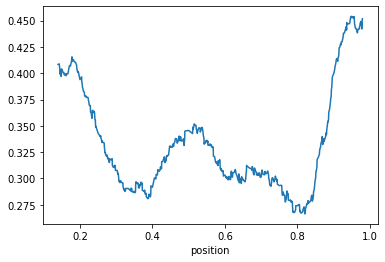

In [106]:
rolling_window = mismatches.groupby('position')['mismatch'].mean().rolling(window=100).mean()

rolling_window.plot();
rolling_window.shape

## Now create bins for positions in verse line

In [13]:
bins = 10 # how many bins?

edges = np.linspace(mismatches.position.min(), mismatches.position.max(), bins+1).astype(float).round(2)

labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
mismatches['position_binned'] = pd.cut(mismatches.position, bins=bins, labels=labels)
mismatches['combo'] = mismatches["ms1"]+'-'+mismatches["ms2"]

mismatches

,ms1,ms2,position,mismatch,position_binned,combo
0,A,B,0.000000,0,"(0.0, 0.1]",A-B
1,A,B,0.037037,0,"(0.0, 0.1]",A-B
2,A,B,0.074074,0,"(0.0, 0.1]",A-B
3,A,B,0.111111,0,"(0.1, 0.2]",A-B
4,A,B,0.148148,0,"(0.1, 0.2]",A-B
...,...,...,...,...,...,...
77946,B,C,0.864865,0,"(0.79, 0.89]",B-C
77947,B,C,0.891892,0,"(0.89, 0.99]",B-C
77948,B,C,0.918919,0,"(0.89, 0.99]",B-C
77949,B,C,0.945946,0,"(0.89, 0.99]",B-C


In [14]:
df_binned = mismatches.groupby(['position_binned', 'combo'])['mismatch'].sum().reset_index()
df_binned

,position_binned,combo,mismatch
0,"(0.0, 0.1]",A-B,720
1,"(0.0, 0.1]",A-C,873
2,"(0.0, 0.1]",B-C,733
3,"(0.1, 0.2]",A-B,583
4,"(0.1, 0.2]",A-C,745
5,"(0.1, 0.2]",B-C,667
6,"(0.2, 0.3]",A-B,555
7,"(0.2, 0.3]",A-C,729
8,"(0.2, 0.3]",B-C,674
9,"(0.3, 0.39]",A-B,607


In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

result_binned = df_binned.pivot(index='combo', columns='position_binned', values='mismatch')
fig, ax = plt.subplots(figsize=(16,10)

sns.heatmap(result_binned, fmt="g", cmap='viridis', linewidths=.5) #annot=True
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-872d62d44a01>, line 7)